In [1]:
# Student: Timur Carstensen
# Student ID: 1722194

In [2]:
#
# IE 678 Deep Learning, University of Mannheim
# Author: Rainer Gemulla

In [3]:
import torch
import torch.nn as nn
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix

from IPython import get_ipython
from helper import *
from util import nextplot

%matplotlib inline

In [4]:
# Use GPU if CUDA is available
DATA_PATH = "data/"
MODEL_PATH = "data/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# To prevent from retraining models, you can save them to disk and load them
# later on
def save(model, filename):
    torch.save(model.state_dict(), os.path.join(MODEL_PATH, filename))


def load(model, filename):
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH, filename)))
    return model

# 1 Convolutional Neural Networks

## Load the data

In [9]:
X, y, Xtest, ytest = load_dataset("fashionmnist")
class_dict = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}
print(f"{len(X)} training examples")
print(f"{len(Xtest)} test examples")

60000 training examples
10000 test examples


Label of example i=0: ankle boot
Label of example i=1: t-shirt/top
Label of example i=2: t-shirt/top
Label of example i=3: dress
Label of example i=4: t-shirt/top


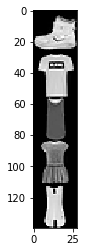

In [10]:
def show_image(x):
    "Show one (or multiple) 28x28 MNIST images as a gray-scale image."
    plt.imshow(x.reshape(-1, 28).cpu(), cmap="gray", interpolation="none")


# Plot first 5 training examples. Each example consists of a 1x28x28 tensor with values
# in [0,1] and a label
nextplot()
show_image(X[:5])
for i in range(5):
    print(f"Label of example i={i}: {class_dict[y[i].item()]}")

## 1a+b Implement a CNN model

In [12]:
# Here is a PyTorch version of logistic regression.
class LogisticRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = nn.Linear(num_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x.float())
        out = self.sigmoid(out)
        return out

In [13]:
# Implement a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Create the required layers/function and store them as instance variables
        # YOUR CODE HERE
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(kernel_size=3, in_channels=1, out_channels=32, stride=1, padding=1, padding_mode="zeros"),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Linear(in_features=6272, out_features=10)
        self.log_softmax = nn.LogSoftmax()
        

    def forward(self, x):
        """
        Perform the forward pass.

        Parameters
        ----------
        x: tensor of shape (batch_size, 1, 28, 28)

        Returns
        -------
        model output as a tensor of shape (batch_size, 10)
        """
        out = None
        # Use the layers/functions created above to compute model output
        # YOUR CODE HERE
        out = self.layer1(x)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.log_softmax(out)
        
        return out

In [10]:
# here is a description of what you created (this uses the member variables)
print(SimpleCNN())

# SimpleCNN(
#   (layer1): Sequential(
#     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#     (1): Sigmoid()
#     (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#   )
#   (fc1): Linear(in_features=6272, out_features=10, bias=True)
#   (log_softmax): LogSoftmax()
# )

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


In [14]:
# One way to see the parameters of your model is to look at its "state". Check that the
# shapes of the parameters that you see here match your computations of task 1a).
model = SimpleCNN().to(DEVICE)
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[-2.4413e-01,  4.2617e-02,  3.1756e-01],
                        [-7.0482e-02,  1.7290e-02, -1.0355e-01],
                        [ 3.1558e-02, -1.2980e-01,  3.2857e-01]]],
              
              
                      [[[ 6.5351e-03,  9.9397e-02, -2.2767e-01],
                        [ 2.9914e-01,  1.1743e-01,  4.4040e-02],
                        [-2.8349e-01, -6.3990e-02,  2.0376e-01]]],
              
              
                      [[[-1.0722e-01,  2.3458e-02,  5.1296e-02],
                        [-6.3506e-03,  1.2136e-01, -1.3855e-01],
                        [ 2.7447e-01,  4.4186e-02, -3.2704e-02]]],
              
              
                      [[[-1.3704e-01, -2.0820e-01,  3.0723e-01],
                        [-2.5863e-01,  2.2444e-01, -1.2951e-01],
                        [ 1.4762e-01, -5.5286e-02,  1.5073e-01]]],
              
              
                      [[[-3.0081e-01, -1.6919e-01,  9.5023e

In [15]:
# Run the forward pass on the first 5 examples.
with torch.no_grad():  # tell torch to not compute backward graph
    print(model(X[:5]))

tensor([[-2.0608, -2.0418, -2.5162, -2.9079, -2.1383, -2.2506, -1.8348, -2.6992,
         -2.2903, -2.8794],
        [-2.2168, -2.3191, -2.3916, -2.8283, -2.5097, -2.3808, -1.7170, -2.3541,
         -2.0668, -2.7011],
        [-2.1600, -2.2941, -2.4255, -2.9933, -2.4440, -2.3244, -1.7916, -2.4609,
         -2.0707, -2.4955],
        [-2.0819, -2.3726, -2.3657, -2.8566, -2.3902, -2.4340, -1.7798, -2.3896,
         -2.2686, -2.4349],
        [-2.2163, -2.3349, -2.3170, -3.0505, -2.3059, -2.3469, -1.7984, -2.3935,
         -2.0606, -2.6784]])


/var/folders/hq/pyn2nf8x3f94nbk8r749084r0000gn/T/ipykernel_72444/260300387.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.log_softmax(out)


     Labels: ['ankle boot', 't-shirt/top', 't-shirt/top', 'dress', 't-shirt/top']
Predictions: ['shirt', 'shirt', 'shirt', 'shirt', 'shirt']


/var/folders/hq/pyn2nf8x3f94nbk8r749084r0000gn/T/ipykernel_72444/260300387.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.log_softmax(out)


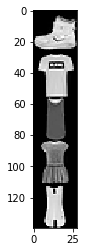

In [16]:
# Plot training (or test) examples, their correct labels, and the most likely model
# predictions. Do not be worried if your (untrained) model always seems to predict the
# same class.
@torch.no_grad()
def mnist_predict(model, start, end=None, use_test_data=False):
    if end is None:
        end = start + 1
    if use_test_data:
        images = Xtest[start:end].to(DEVICE)
        labels = ytest[start:end].to(DEVICE)
    else:
        images = X[start:end].to(DEVICE)
        labels = y[start:end].to(DEVICE)
    nextplot()
    show_image(images)
    print("     Labels:", [class_dict[label.item()] for label in labels])
    out = model(images)
    _, yhat = torch.max(out, 1)
    print("Predictions:", [class_dict[pred.item()] for pred in yhat])


# first 5 examples from training + predictions
mnist_predict(model, 0, 5)

## 1c Evaluate model performance

In [17]:
# test model
@torch.no_grad()
def mnist_test(model, batch_size=100, reshape_1d=False):
    """
    Function to test your CNN on test data

    Parameters
    ----------

    model: trained CNN from task 1a
    batch_size: size of batch for dataloader
    reshape_1d: Reshape images to a 1d vectors (allows use of models other than CNNs
                such as fully-connected FNNs)

    Returns
    -------
    accuracy of input model
    """
    correct = 0  # number of correct predictions
    total = 0  # total number of examples
    model.eval()  # set layers like dropout and batch norm to eval mode

    # Create test data loader
    if reshape_1d:
        dataset = torch.utils.data.TensorDataset(Xtest.reshape(len(Xtest), -1), ytest)
    else:
        dataset = torch.utils.data.TensorDataset(Xtest, ytest)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False
    )
    # confusion_matrix = np.zeros(shape=(10,10))
    pred = list()
    y = list()
    # Loop over data
    for batch in test_loader:
        # YOUR CODE HERE
        # Update correct and total using the examples in the batch. To understand what a
        # DataLoader does, have a look at the contents of "batch" before you start.
        images, labels = batch
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted)
        y.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # confusion matrix over classes
            
    M = confusion_matrix(torch.cat(y), torch.cat(pred))
    accuracy = (correct / total) * 100
    print(f"Accuracy on {total} test images: {accuracy:.2f} %")
    return accuracy, M

In [18]:
# Test your code. Output should be: 6.97%
class DummyModel(nn.Module):
    def forward(self, x):
        return x.reshape(len(x), -1)[:, 200:210] * torch.arange(10).to(DEVICE)


mnist_test(DummyModel().to(DEVICE))[0]

Accuracy on 10000 test images: 6.97 %


6.97

## 1d Train a model

In [19]:
# train model
def mnist_train(
    model, num_epochs=5, learning_rate=0.001, batch_size=100, reshape_1d=False
):
    """
    Function to train the provided CNN network.

    Parameters
    ----------
    model: the model to train
    num_epochs: number of epochs to train
    learning_rate: learning rate to use
    batch_size: size of batch for data loader
    reshape_1d: Reshape images to a 1d vectors (allows use of models other than CNNs
                such as fully-connected FNNs)
    """
    # YOUR CODE HERE

    if reshape_1d:
        dataset = torch.utils.data.TensorDataset(X.reshape(len(X), -1), y)
    else:
        dataset = torch.utils.data.TensorDataset(X, y)
    test_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    i = 0
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        
        for batch in test_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            i += 1
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0


    return model

## 1e Train and evaluate the simple CNN model

In [34]:
# load model
load(model, "simple_cnn.pt")

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)

In [30]:
# Train a model.
model = mnist_train(SimpleCNN().to(DEVICE))

/var/folders/hq/pyn2nf8x3f94nbk8r749084r0000gn/T/ipykernel_72444/260300387.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.log_softmax(out)


[4,  2000] loss: 0.027


In [35]:
# persisting the model
save(model, "simple_cnn.pt")

/var/folders/hq/pyn2nf8x3f94nbk8r749084r0000gn/T/ipykernel_72444/260300387.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.log_softmax(out)


Accuracy on 10000 test images: 87.29 %


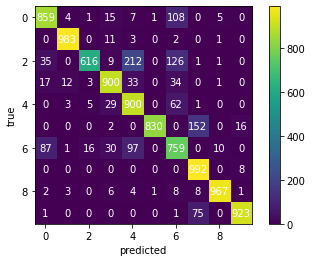

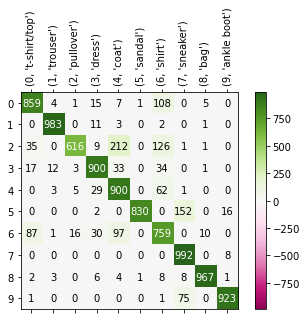

In [43]:
# Test a model. The simple CNN should perform much better after training.
# model = load(SimpleCNN(), "simple_cnn.pt").to(DEVICE)
_, M = mnist_test(model)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()
plt.savefig("tex/assets/conf_mat.png", dpi=1000)
acc = M.diagonal()/M.sum(axis=1)
from util import plot_matrix

out = {v:acc[i] for i, (k, v) in enumerate(class_dict.items())}
plot_matrix(M, colnames=class_dict.items())

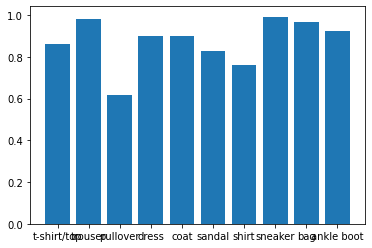

<Figure size 432x288 with 0 Axes>

In [42]:
nextplot()
plt.bar(range(len(out)), list(out.values()), align='center')
plt.xticks(range(len(out)), list(out.keys()))
plt.show()
plt.savefig("tex/assets/accuracies_per_class.png", dpi=200)

## 1f Sandbox

In [45]:
# try adding more layers, regularization, etc.
class MyCnn(nn.Module):
    def __init__(self):
        super(MyCnn, self).__init__()
        # YOUR CODE HERE

    def forward(self, x):
        out = None
        # YOUR CODE HERE

        return out

In [46]:
my_cnn = MyCnn().to(DEVICE)

In [ ]:
# train
mnist_train(my_cnn)
# save(my_cnn, "my_cnn.pt")

In [ ]:
# test
# my_cnn = load(my_cnn, "my_cnn.pt")
mnist_test(my_cnn)

# 2 Recurrent Neural Networks and Pretraining

## Load and preprocess the data

In [44]:
# Load review and label data
with open(os.path.join(DATA_PATH, "reviews_small.txt")) as f:
    reviews_lines = f.readlines()

with open(os.path.join(DATA_PATH, "labels_small.txt")) as f:
    label_lines = f.readlines()

print(reviews_lines[0])
print(label_lines[0])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   

positive



In [45]:
# Remove punctuations from the reviews and split words
raw_reviews, words, labels = reviews_preprocess(reviews_lines, label_lines)
print(raw_reviews[0])
print("First ten words: ", words[:10])
print("First label: ", labels[0])

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my years in the teaching profession lead me to believe that bromwell high s satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i m here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn t
First ten words:  ['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']
First label:  1


In [46]:
# Determine an integer id for each unique word
word_ids = reviews_create_word_ids(words)
print(word_ids.get("the"))
print(word_ids.get("movie"))

1
16


In [47]:
# Encode each word in the review by its unique identifier
encoded_reviews = reviews_encode(word_ids, raw_reviews)
print(raw_reviews[0])
print(encoded_reviews[0])

bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my years in the teaching profession lead me to believe that bromwell high s satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i m here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it isn t
[10455, 307, 6, 3, 1177, 202, 8, 2217, 33, 1, 168, 56, 15, 49, 85, 8269, 43, 422, 122, 140, 15, 3151, 59, 144, 9, 1, 5230, 5946, 452, 72, 5, 260, 12, 10455, 307, 13, 2017, 6, 73, 2765, 5, 689, 76, 6, 3151, 1, 19565, 5, 1706, 6897, 1, 5947,

In [48]:
# Padding/truncating all reviews to the same length. Although this isn't strictly
# necessary, it facilitates batch processing: all inputs of a batch need to have the
# same length.
sequence_length = 200
padded_reviews = reviews_pad(encoded_reviews, sequence_length)
print(padded_reviews[0])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 10455   307     6     3  1177   202     8  2217    33     1   168    56
    15    49    85  8269    43   422   122   140    15  3151    59   144
     9     1  5230  5946   452    72     5   260    12 10455   307    13
  2017     6    73  2765     5   689    76     6  3151     1 19565     5
  1706  6897     1  5947  1707    36    52    68   211   143    63  1390
  3151 14816     1 19566     4     1   221   755    31  2710    72     4
     1  5948    10   729     2    63  1707    54    10   208     1   321
     9    64     3  1578  3922   737     5  2843   187     1   422    10
  1246  9217    33   307     3   380   322  5949   

In [49]:
# Split dataset into 80% training, 10% test, and 10% validation Dataset
train_x, train_y, valid_x, valid_y, test_x, test_y = reviews_split(
    padded_reviews, labels
)
print(len(train_y), len(valid_y), len(test_y))

3200 400 400


In [50]:
# Create data loaders for training
train_loader, valid_loader, test_loader = reviews_create_dataloaders(
    train_x, train_y, valid_x, valid_y, test_x, test_y
)

In [51]:
# Here is an example how to use the train and test functions. Note that logistic
# regression is a bogus model when used like this (since its assigns weights to
# positions, but not word ids). So results will be bad.
model = LogisticRegression(sequence_length).to(DEVICE)
reviews_train(model, train_loader, valid_loader, epochs=3, device=DEVICE)
reviews_test(model, test_loader, device=DEVICE)

Starting epoch 1
Epoch:  1/ 3    Batch:  5   Batch loss: 55.862564    Val loss: 52.007381 Val acc: 0.470000
Epoch:  1/ 3    Batch: 10   Batch loss: 44.230236    Val loss: 50.456723 Val acc: 0.490000
Epoch:  1/ 3    Batch: 15   Batch loss: 50.000000    Val loss: 50.462179 Val acc: 0.490000
Epoch:  1/ 3    Batch: 20   Batch loss: 44.000000    Val loss: 50.634626 Val acc: 0.490000
Epoch:  1/ 3    Batch: 25   Batch loss: 32.900143    Val loss: 52.853641 Val acc: 0.470000
Epoch:  1/ 3    Batch: 30   Batch loss: 52.671864    Val loss: 51.840658 Val acc: 0.480000
Epoch:  1/ 3    Batch: 35   Batch loss: 62.000000    Val loss: 52.332016 Val acc: 0.470000
Epoch:  1/ 3    Batch: 40   Batch loss: 53.558922    Val loss: 51.445327 Val acc: 0.480000
Epoch:  1/ 3    Batch: 45   Batch loss: 48.000038    Val loss: 51.347229 Val acc: 0.480000
Epoch:  1/ 3    Batch: 50   Batch loss: 58.108727    Val loss: 51.581363 Val acc: 0.480000
Epoch:  1/ 3    Batch: 55   Batch loss: 54.000000    Val loss: 51.581363 

## 2a Define your model

In [63]:
# Create an LSTM for sentiment analysis
class SimpleLSTM(nn.Module):
    """
    The RNN model that will be used to perform sentiment analysis.
    """

    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        num_layers=1,
        lstm_dropout_prob=0.5,
        dropout_prob=0.3,
    ):
        """
        Initialize the model by setting up the layers

        Parameters
        ----------
        vocab_size: number of unique words in the reviews
        embeddings_dim: size of the embeddings
        hidden_dim: dimension of the LSTM output
        num_layers: number of LSTM layers
        lstm_dropout_prob: dropout applied between the LSTM layers
        dropout_prob: dropout applied before the fully connected layer
        """
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=embedding_dim
            )

        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=lstm_dropout_prob
            )
        
        self.dropout = nn.Dropout(
            p=dropout_prob, 
            inplace=False
            )
        
        self.fc = nn.Linear(
            in_features=hidden_dim, 
            out_features=1
            )

        self.sigmoid = nn.Sigmoid()


        # YOUR CODE HERE

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.

        Parameters
        ----------
        x: batch as a (batch_size, sequence_length) tensor

        Returns
        -------
        Probability of positive class.
        """
        # init hidden layer, which is needed for the LSTM
        batch_size = len(x)
        hidden = self.init_hidden(batch_size)
    
        # YOUR CODE HERE
        embedding = self.embedding(x)         
        out, (hidden, cell_state) = self.lstm(embedding, hidden)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
        

    def init_hidden(self, batch_size):
        """
        Initialize hidden state.

        Returns
        -------
        Empty hidden LSTM state.
        """

        # Create two new tensors with sizes num_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters())  # only used to determine device

        hidden = (
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
        )

        return hidden

In [64]:
# Test model setup
lstm_model = SimpleLSTM(1, 10, 32, 2, 0, 0).to(DEVICE)
print(lstm_model)

# SimpleLSTM(
#   (embedding): Embedding(1, 10)
#   (lstm): LSTM(10, 32, num_layers=2, batch_first=True, dropout=0.0)
#   (dropout): Dropout(p=0.0, inplace=False)
#   (fc): Linear(in_features=32, out_features=1, bias=True)
#   (sigmoid): Sigmoid()
# )

SimpleLSTM(
  (embedding): Embedding(1, 10)
  (lstm): LSTM(10, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [65]:
# Test forward function. 
# dummy data
dummy_data = torch.zeros(train_loader.batch_size, sequence_length).long().to(DEVICE)
# fix model parameters
for key in lstm_model.state_dict():
    lstm_model.state_dict()[key][:] = 0.1
print(lstm_model(dummy_data).reshape(10, -1))
# Output after reshape should be the following tensor
#tensor([[0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
#        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643]], device='cuda or cpu',
#       grad_fn=<ViewBackward>)

tensor([[0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643],
        [0.9643, 0.9643, 0.9643, 0.9643, 0.9643]],
       grad_fn=<ReshapeAliasBackward0>)


## 2b Train and evaluate the model

In [66]:
# Instantiate the model w/ hyperparams
vocab_size = len(word_ids) + 1  # +1 for the 0 padding
embedding_dim = 100
hidden_dim = 64
num_layers = 1

# this may raise a warning when num_layers=1 (which is fine)
# make sure to reinizialize the model if you want to train multiple times
lstm_model = SimpleLSTM(vocab_size, embedding_dim, hidden_dim, num_layers).to(DEVICE)

In [57]:
# Fit and evaluate a model (without pretrained embeddings)
n_epochs = 5
# YOUR CODE HERE
reviews_train(lstm_model, train_loader, valid_loader, epochs=5, device=DEVICE)

Starting epoch 1
Epoch:  1/ 5    Batch:  5   Batch loss: 0.679525    Val loss: 0.703965 Val acc: 0.495000
Epoch:  1/ 5    Batch: 10   Batch loss: 0.698851    Val loss: 0.695553 Val acc: 0.517500
Epoch:  1/ 5    Batch: 15   Batch loss: 0.705797    Val loss: 0.695675 Val acc: 0.512500
Epoch:  1/ 5    Batch: 20   Batch loss: 0.708614    Val loss: 0.694467 Val acc: 0.550000
Epoch:  1/ 5    Batch: 25   Batch loss: 0.667098    Val loss: 0.693591 Val acc: 0.547500
Epoch:  1/ 5    Batch: 30   Batch loss: 0.688021    Val loss: 0.694176 Val acc: 0.530000
Epoch:  1/ 5    Batch: 35   Batch loss: 0.679528    Val loss: 0.693740 Val acc: 0.540000
Epoch:  1/ 5    Batch: 40   Batch loss: 0.673149    Val loss: 0.693195 Val acc: 0.552500
Epoch:  1/ 5    Batch: 45   Batch loss: 0.683008    Val loss: 0.691528 Val acc: 0.547500
Epoch:  1/ 5    Batch: 50   Batch loss: 0.701330    Val loss: 0.689682 Val acc: 0.550000
Epoch:  1/ 5    Batch: 55   Batch loss: 0.668185    Val loss: 0.687032 Val acc: 0.547500
Epoc

In [68]:
reviews_test(lstm_model, test_loader, device=DEVICE)

Test loss: 0.918
Test accuracy: 0.682


## 2c Load pretrained word embeddings

In [69]:
@torch.no_grad()
def reviews_load_embeddings(
    embedding_layer, word_ids, pretrained_embeddings_file="data/word-embeddings.txt"
):
    """Load pretrained embeddings into an embedding layer.

    Updates the weights of the embedding layer with with the embeddings given in the
    provided word embeddings file.

    Parameters
    ----------
    embedding_layer: torch.nn.Embedding used in the model
    word_ids: dictionary mapping each word to its unique identifier
    pretrained_embeddings_file: path to the file containing pretrained embeddings

    """
    print("Initializing embedding layer with pretrained word embeddings...")
    embeddings_index = dict()
    words_initialized = 0
    with open(pretrained_embeddings_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            encoded_word = word_ids.get(word)
            if encoded_word is not None:
                words_initialized += 1
                embedding_layer.weight[encoded_word, :] = torch.from_numpy(
                    np.asarray(values[1:], dtype="float32")
                )
    print(
        "Initialized {}/{} word embeddings".format(
            words_initialized, embedding_layer.num_embeddings
        )
    )

In [70]:
# Try it
test_embeddings = nn.Embedding(len(word_ids) + 1, 100).to(DEVICE)
reviews_load_embeddings(test_embeddings, word_ids)
print(test_embeddings(torch.LongTensor([word_ids.get("movie")]).to(DEVICE)))
del test_embeddings

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
tensor([[ 0.3825,  0.1482,  0.6060, -0.5153,  0.4399,  0.0611, -0.6272, -0.0254,
          0.1643, -0.2210,  0.1442, -0.3721, -0.2168, -0.0890,  0.0979,  0.6561,
          0.6446,  0.4770,  0.8385,  1.6486,  0.8892, -0.1181, -0.0125, -0.5208,
          0.7785,  0.4872, -0.0150, -0.1413, -0.3475, -0.2959,  0.1028,  0.5719,
         -0.0456,  0.0264,  0.5382,  0.3226,  0.4079, -0.0436, -0.1460, -0.4835,
          0.3204,  0.5509, -0.7626,  0.4327,  0.6175, -0.3650, -0.6060, -0.7962,
          0.3929, -0.2367, -0.3472, -0.6120,  0.5475,  0.9481,  0.2094, -2.7771,
         -0.6022,  0.8495,  1.2549,  0.0179, -0.0419,  2.1147, -0.0266, -0.2810,
          0.6812, -0.1417,  0.9925,  0.4988, -0.6754,  0.6417,  0.4230, -0.2791,
          0.0634,  0.6891, -0.3618,  0.0537, -0.1681,  0.1942, -0.4707, -0.1480,
         -0.5899, -0.2797,  0.1679,  0.1057, -1.7601,  0.0088, -0.8333, -0.5836,
     

In [71]:
emmbed_dict = {}
number_lines = 0
with open("data/word-embeddings.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        emmbed_dict[word]=vector
        number_lines += 1
print(f"Number of words in Glove Embedding: {number_lines}")

Number of words in Glove Embedding: 29841


In [73]:
len(emmbed_dict['in'])
# each word is associated with a vector of length 100

100

length of word ids is 32363 and the number of words in the embedding file is 29841; every word from the embedding file is used in the review dataset

## 2d Train and evaluate with pretraining

In [74]:
# Fit and evaluate a model with pretrained embeddings without fine-tuning
class EmbeddingLSTM(nn.Module):
    """
    The RNN model that will be used to perform sentiment analysis.
    """

    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        num_layers=1,
        lstm_dropout_prob=0.5,
        dropout_prob=0.3,
        finetuning=False
    ):
        """
        Initialize the model by setting up the layers

        Parameters
        ----------
        vocab_size: number of unique words in the reviews
        embeddings_dim: size of the embeddings
        hidden_dim: dimension of the LSTM output
        num_layers: number of LSTM layers
        lstm_dropout_prob: dropout applied between the LSTM layers
        dropout_prob: dropout applied before the fully connected layer
        """
        super().__init__()
        self.finetuning = finetuning
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=embedding_dim
            )

        reviews_load_embeddings(embedding_layer=self.embedding, word_ids=word_ids)

        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=lstm_dropout_prob
            )
        
        self.dropout = nn.Dropout(
            p=dropout_prob, 
            inplace=False
            )
        
        self.fc = nn.Linear(
            in_features=hidden_dim, 
            out_features=1
            )

        self.sigmoid = nn.Sigmoid()


        # YOUR CODE HERE

    def forward(self, x):
        """
        Perform a forward pass of our model on some input and hidden state.

        Parameters
        ----------
        x: batch as a (batch_size, sequence_length) tensor

        Returns
        -------
        Probability of positive class.
        """
        # init hidden layer, which is needed for the LSTM
        batch_size = len(x)
        hidden = self.init_hidden(batch_size)
        
        # YOUR CODE HERE

        self.embedding.weight.requires_grad = self.finetuning
        embedding = self.embedding(x)        
        out, (hidden, cell_state) = self.lstm(embedding, hidden)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
        
    def init_hidden(self, batch_size):
        """
        Initialize hidden state.

        Returns
        -------
        Empty hidden LSTM state.
        """

        # Create two new tensors with sizes num_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters())  # only used to determine device

        hidden = (
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
            weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
        )

        return hidden

In [88]:
# Fit and evaluate a model with pretrained embeddings without fine-tuning.
# YOUR CODE HERE
vocab_size = len(word_ids) + 1  # +1 for the 0 padding
embedding_dim = 100
hidden_dim = 64
num_layers = 1

embedding_model = EmbeddingLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, finetuning=False).to(DEVICE)
reviews_train(embedding_model, train_loader, valid_loader, epochs=5, device=DEVICE)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Starting epoch 1
Epoch:  1/ 5    Batch:  5   Batch loss: 0.686438    Val loss: 0.706561 Val acc: 0.515000
Epoch:  1/ 5    Batch: 10   Batch loss: 0.695074    Val loss: 0.686327 Val acc: 0.527500
Epoch:  1/ 5    Batch: 15   Batch loss: 0.666638    Val loss: 0.684639 Val acc: 0.532500
Epoch:  1/ 5    Batch: 20   Batch loss: 0.679411    Val loss: 0.683167 Val acc: 0.547500
Epoch:  1/ 5    Batch: 25   Batch loss: 0.628898    Val loss: 0.688541 Val acc: 0.545000
Epoch:  1/ 5    Batch: 30   Batch loss: 0.701615    Val loss: 0.675063 Val acc: 0.570000
Epoch:  1/ 5    Batch: 35   Batch loss: 0.747103    Val loss: 0.689529 Val acc: 0.550000
Epoch:  1/ 5    Batch: 40   Batch loss: 0.657241    Val loss: 0.673139 Val acc: 0.570000
Epoch:  1/ 5    Batch: 45   Batch loss: 0.644778    Val loss: 0.669597 Val acc: 0.582500
Epoch:  1/ 5    Batch: 50   Batch loss: 0.652246    Val loss: 0.678360 Val acc

In [84]:
reviews_test(embedding_model, test_loader, device=DEVICE)

Test loss: 0.548
Test accuracy: 0.725


In [85]:
# Fit and evaluate a model with pretrained embeddings with fine-tuning.
# YOUR CODE HERE
vocab_size = len(word_ids) + 1  # +1 for the 0 padding
embedding_dim = 100
hidden_dim = 64
num_layers = 1

embedding_model = EmbeddingLSTM(vocab_size, embedding_dim, hidden_dim, num_layers, finetuning=True).to(DEVICE)
reviews_train(embedding_model, train_loader, valid_loader, epochs=5, device=DEVICE)

Initializing embedding layer with pretrained word embeddings...
Initialized 29841/32363 word embeddings
Starting epoch 1
Epoch:  1/ 5    Batch:  5   Batch loss: 0.675380    Val loss: 0.703210 Val acc: 0.502500
Epoch:  1/ 5    Batch: 10   Batch loss: 0.673556    Val loss: 0.688418 Val acc: 0.552500
Epoch:  1/ 5    Batch: 15   Batch loss: 0.688058    Val loss: 0.686013 Val acc: 0.530000
Epoch:  1/ 5    Batch: 20   Batch loss: 0.692807    Val loss: 0.685314 Val acc: 0.555000
Epoch:  1/ 5    Batch: 25   Batch loss: 0.675730    Val loss: 0.689419 Val acc: 0.520000
Epoch:  1/ 5    Batch: 30   Batch loss: 0.663634    Val loss: 0.682638 Val acc: 0.555000
Epoch:  1/ 5    Batch: 35   Batch loss: 0.671265    Val loss: 0.676966 Val acc: 0.600000
Epoch:  1/ 5    Batch: 40   Batch loss: 0.675061    Val loss: 0.672660 Val acc: 0.602500
Epoch:  1/ 5    Batch: 45   Batch loss: 0.633352    Val loss: 0.673495 Val acc: 0.580000
Epoch:  1/ 5    Batch: 50   Batch loss: 0.666285    Val loss: 0.668230 Val acc

In [86]:
reviews_test(embedding_model, test_loader, device=DEVICE)

Test loss: 0.558
Test accuracy: 0.770


## 2e Sandbox

In [ ]:
# Explore different architectures and hyperparameters.